In [30]:
#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from collections import Counter

#language processors
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from string import punctuation

#metrics and preprocessors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder  
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

#models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,GaussianNB
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,VotingClassifier,StackingClassifier


In [6]:
!pip install --upgrade numexpr
!pip install --upgrade bottleneck

^C


In [33]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [35]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [36]:
df.duplicated().sum()

403

In [37]:
df.drop_duplicates(keep='first')

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [38]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [39]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# EDA

In [40]:
df['target'].value_counts()

target
0    4825
1     747
Name: count, dtype: int64

#Data is imbalanced

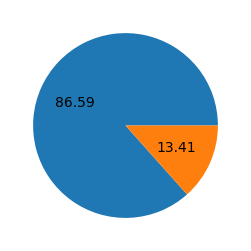

In [41]:
plt.figure(figsize=(6,3))
plt.pie(x=df['target'].value_counts(),autopct='%0.2f')
plt.show()

In [42]:
#Length of text messages:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
df['num_char'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentnce'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_char,num_words,num_sentnce
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [44]:
df[df['target'] == 0].describe()

,target,num_char,num_words,num_sentnce
count,4825.0,4825.000000,4825.000000,4825.000000
mean,0.0,71.023627,17.271917,1.808705
std,0.0,58.016023,13.988885,1.328227
min,0.0,2.000000,1.000000,1.000000
25%,0.0,33.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,92.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,28.000000


In [45]:
df[df['target'] == 1].describe()

,target,num_char,num_words,num_sentnce
count,747.0,747.000000,747.000000,747.000000
mean,1.0,138.866131,27.891566,3.017403
std,0.0,29.183082,6.867007,1.528449
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.500000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,8.000000


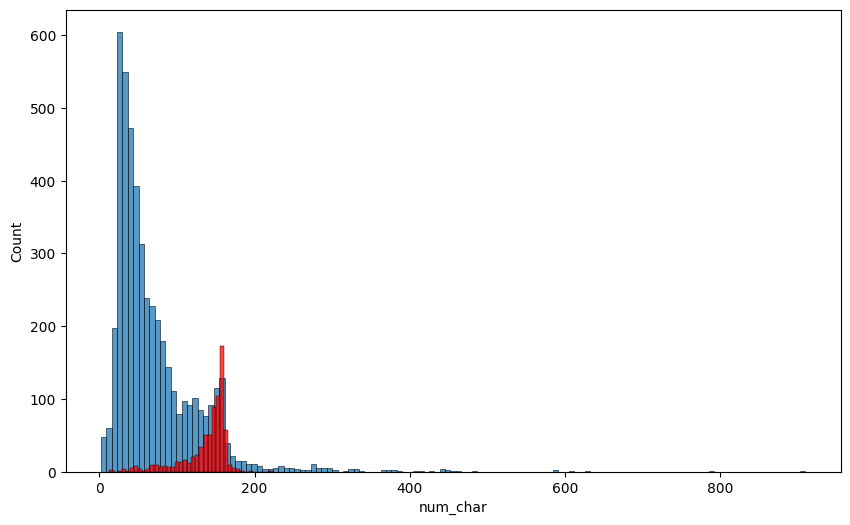

In [46]:
plt.figure(figsize=(10,6))
sns.histplot(x = df[df['target'] == 0]['num_char'])
sns.histplot(x = df[df['target'] == 1]['num_char'],color='red')
plt.show()

C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Nikhi\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


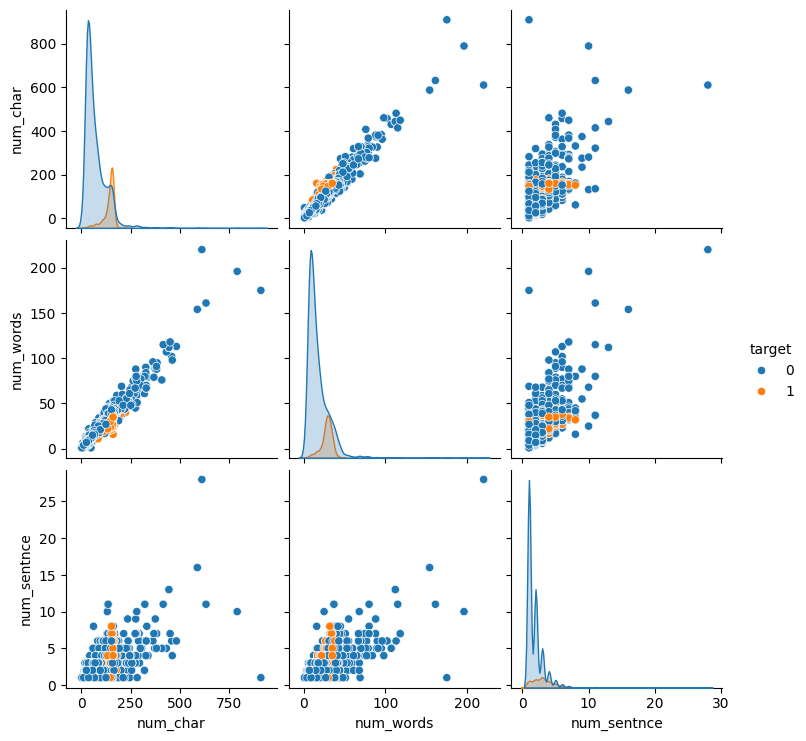

In [47]:
sns.pairplot(df,hue='target')

<Axes: >

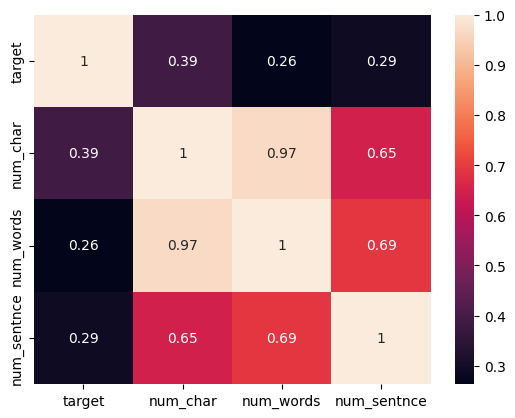

In [48]:
sns.heatmap(df.corr(numeric_only = True),annot = True)

In [49]:
# Data Preprocessing
ps = PorterStemmer()

def transform_txt(txt):
    txt = txt.lower()
    txt = nltk.word_tokenize(txt)
    
    y = []
    for i in txt:
        if i.isalnum():
            y.append(i)
            
    txt = y[:]
    y.clear()
        
    for i in txt:
        if i not in stopwords.words('english') and i not in punctuation:
            y.append(i)
            
    txt = y[:]
    y.clear()
        
    for i in txt:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [50]:
transform_txt("The Porter stemming algorithm, introduced by Martin Porter in 1980, follows a set of rules to perform stemming.")

'porter stem algorithm introduc martin porter 1980 follow set rule perform stem'

In [51]:
df['transformed_text'] = df['text'].apply(transform_txt)

In [52]:
df.head()

,target,text,num_char,num_words,num_sentnce,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [53]:
wc = WordCloud(width=500,height=500,font_step=10,background_color='black')
spam_wc = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))

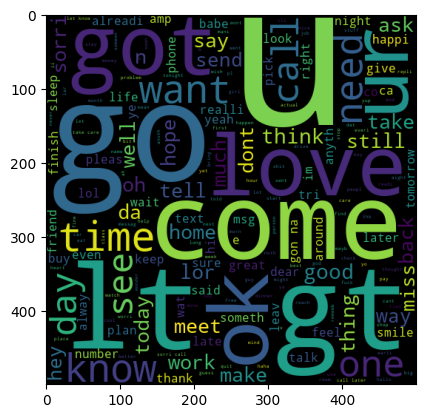

In [54]:
plt.imshow(spam_wc)

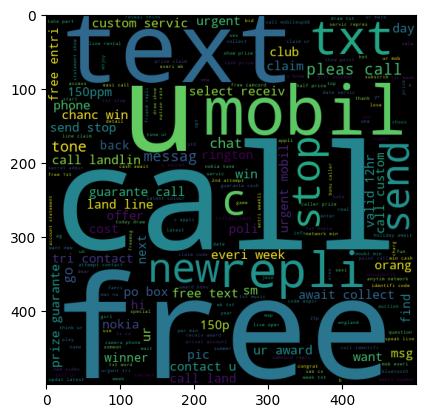

In [29]:
plt.imshow(ham_wc)

In [55]:
# extracting top 30 ham and spam words:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].to_list():
    for word in msg.split():
        spam_corpus.append(word)

In [56]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].to_list():
    for word in msg.split():
        ham_corpus.append(word)

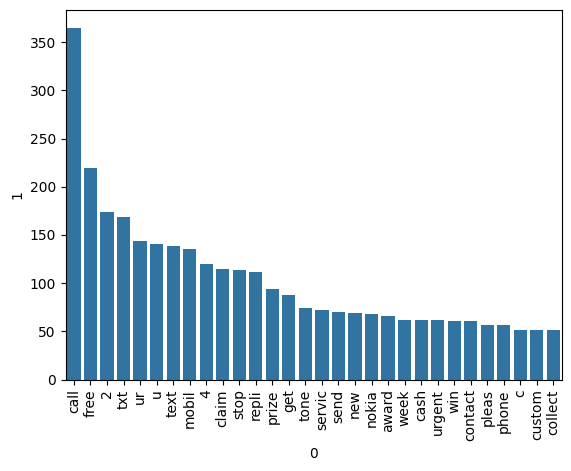

In [57]:
sns.barplot(x = pd.DataFrame(Counter(spam_corpus).most_common(30))[0],y = pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

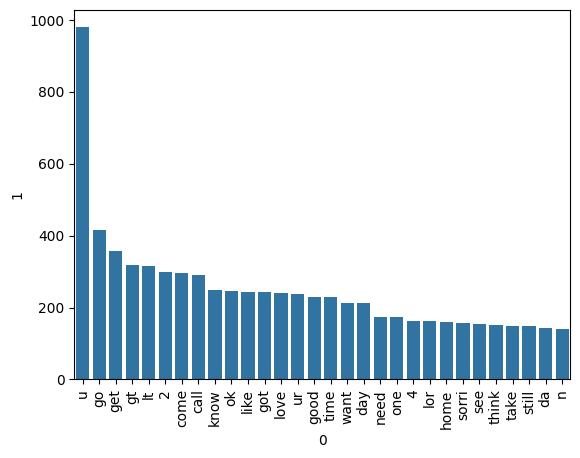

In [58]:
sns.barplot(x = pd.DataFrame(Counter(ham_corpus).most_common(30))[0],y = pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

# MODEL BUILDING + TEXT VECTORIZATION

# Bag of Words

In [109]:
cv = CountVectorizer()
X = cv.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [110]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
print(X_train.shape,y_train.shape)

(4457, 6708) (4457,)


In [61]:
# Naive Bayes:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [62]:
naivebayes_clf = {'GaussianNB':gnb,
                 'MultinomialNB':mnb,
                 'BernoulliNB':bnb}

In [63]:
def train_NB_clf(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [114]:
accuracy = []
precision = []

for name,classifer in naivebayes_clf.items():
    currentAccuracy,currentPrecision = train_NB_clf(classifer,X_train,y_train,X_test,y_test)
    print('For',name)
    print('Accuracy_score',currentAccuracy)
    print('Precision_score',currentPrecision)
    
    accuracy.append(currentAccuracy)
    precision.append(currentPrecision)

For GaussianNB
Accuracy_score 0.873542600896861
Precision_score 0.5346938775510204
For MultinomialNB
Accuracy_score 0.9713004484304932
Precision_score 0.9038461538461539
For BernoulliNB
Accuracy_score 0.9695067264573991
Precision_score 0.9920634920634921


In [117]:
NB_performanceCV = pd.DataFrame({'Algorithm':naivebayes_clf.keys(),'Accuracy_score':accuracy,'Precision_score':precision}).sort_values('Precision_score',ascending=False)
NB_performanceCV

,Algorithm,Accuracy_score,Precision_score
2,BernoulliNB,0.969507,0.992063
1,MultinomialNB,0.971300,0.903846
0,GaussianNB,0.873543,0.534694


# TF - IDF

In [66]:
tf = TfidfVectorizer()
X = tf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
print(X_train.shape,y_train.shape)

(4457, 6708) (4457,)


In [67]:
accuracy = []
precision = []

for name,classifer in naivebayes_clf.items():
    currentAccuracy,currentPrecision = train_NB_clf(classifer,X_train,X_test,y_train,y_test)
    print('For',name)
    print('Accuracy_score',currentAccuracy)
    print('Precision_score',currentPrecision)
    
    accuracy.append(currentAccuracy)
    precision.append(currentPrecision)

For GaussianNB
Accuracy_score 0.8690582959641255
Precision_score 0.5252100840336135
For MultinomialNB
Accuracy_score 0.957847533632287
Precision_score 1.0
For BernoulliNB
Accuracy_score 0.9695067264573991
Precision_score 0.9920634920634921


In [68]:
NB_performanceTF = pd.DataFrame({'Algorithm':naivebayes_clf.keys(),'Accuracy_score':accuracy,'Precision_score':precision}).sort_values('Precision_score',ascending=False)
NB_performanceTF

,Algorithm,Accuracy_score,Precision_score
1,MultinomialNB,0.957848,1.000000
2,BernoulliNB,0.969507,0.992063
0,GaussianNB,0.869058,0.525210


# using every other classifiers :

In [129]:
xgb = XGBClassifier()
svc = SVC(kernel='sigmoid', gamma=1.0)
kNc = KNeighborsClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
etc = ExtraTreeClassifier(max_depth=5, random_state=2)
etsc = ExtraTreesClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbc = GradientBoostingClassifier(n_estimators=50,random_state=2)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [130]:
clfs = {'XGBoost':xgb,
        'SVM':svc,
        'multiNB':mnb,
        'KnearestNeig':kNc,
        'logisticReg':lrc,
        'decisionTree':dtc,
        'Xtratree':etc,
        'Xtratrees':etsc,
        'AdaBoost':abc,
        'Bagging':bc,
        'GradientBoost':gbc, 
        'RandomFor':rfc
       }

In [131]:
#for BOW
cv = CountVectorizer()
X = cv.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [132]:
def train_clf(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [134]:
accuracy = []
precision = []

for name,classifer in clfs.items():
    currentAccuracy,currentPrecision = train_clf(classifer,X_train,X_test,y_train,y_test)
    print('For',name)
    print('Accuracy_score',currentAccuracy)
    print('Precision_score',currentPrecision)
    
    accuracy.append(currentAccuracy)
    precision.append(currentPrecision)

For XGBoost
Accuracy_score 0.968609865470852
Precision_score 0.9694656488549618
For SVM
Accuracy_score 0.9273542600896861
Precision_score 0.8031496062992126
For multiNB
Accuracy_score 0.9713004484304932
Precision_score 0.9038461538461539


C:\Users\Nikhi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For KnearestNeig
Accuracy_score 0.905829596412556
Precision_score 1.0
For logisticReg
Accuracy_score 0.9695067264573991
Precision_score 0.984375
For decisionTree
Accuracy_score 0.905829596412556
Precision_score 0.9206349206349206
For Xtratree
Accuracy_score 0.8968609865470852
Precision_score 0.7866666666666666
For Xtratrees
Accuracy_score 0.967713004484305
Precision_score 1.0
For AdaBoost
Accuracy_score 0.9560538116591928
Precision_score 0.9291338582677166
For Bagging
Accuracy_score 0.9650224215246637
Precision_score 0.976
For GradientBoost
Accuracy_score 0.9381165919282511
Precision_score 0.9587628865979382
For RandomFor
Accuracy_score 0.9623318385650225
Precision_score 1.0


In [137]:
performanceCV = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy,'Precision':precision}).sort_values('Precision',ascending=False)
performanceCV

,Algorithm,Accuracy,Precision
3,KnearestNeig,0.905830,1.000000
7,Xtratrees,0.967713,1.000000
11,RandomFor,0.962332,1.000000
4,logisticReg,0.969507,0.984375
9,Bagging,0.965022,0.976000
0,XGBoost,0.968610,0.969466
10,GradientBoost,0.938117,0.958763
8,AdaBoost,0.956054,0.929134
5,decisionTree,0.905830,0.920635
2,multiNB,0.971300,0.903846


In [160]:
#for TFIDF
tf = TfidfVectorizer()
X = tf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [161]:
accuracy = []
precision = []

for name,classifer in clfs.items():
    currentAccuracy,currentPrecision = train_clf(classifer,X_train,X_test,y_train,y_test)
    print('For',name)
    print('Accuracy_score',currentAccuracy)
    print('Precision_score',currentPrecision)
    
    accuracy.append(currentAccuracy)
    precision.append(currentPrecision)

For XGBoost
Accuracy_score 0.968609865470852
Precision_score 0.9767441860465116
For SVM
Accuracy_score 0.9659192825112107
Precision_score 0.9761904761904762
For multiNB
Accuracy_score 0.957847533632287
Precision_score 1.0


C:\Users\Nikhi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For KnearestNeig
Accuracy_score 0.8986547085201794
Precision_score 1.0
For logisticReg
Accuracy_score 0.9443946188340807
Precision_score 0.9444444444444444
For decisionTree
Accuracy_score 0.9246636771300448
Precision_score 0.87
For Xtratree
Accuracy_score 0.8753363228699551
Precision_score 0.7209302325581395
For Xtratrees
Accuracy_score 0.9739910313901345
Precision_score 1.0
For AdaBoost
Accuracy_score 0.9533632286995516
Precision_score 0.9344262295081968
For Bagging
Accuracy_score 0.9587443946188341
Precision_score 0.9242424242424242
For GradientBoost
Accuracy_score 0.9426008968609866
Precision_score 0.9607843137254902
For RandomFor
Accuracy_score 0.9641255605381166
Precision_score 0.9836065573770492


In [162]:
performanceTF = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy,'Precision':precision}).sort_values('Precision',ascending=False)
performanceTF

,Algorithm,Accuracy,Precision
2,multiNB,0.957848,1.000000
3,KnearestNeig,0.898655,1.000000
7,Xtratrees,0.973991,1.000000
11,RandomFor,0.964126,0.983607
0,XGBoost,0.968610,0.976744
1,SVM,0.965919,0.976190
10,GradientBoost,0.942601,0.960784
4,logisticReg,0.944395,0.944444
8,AdaBoost,0.953363,0.934426
9,Bagging,0.958744,0.924242


In [148]:
# TFIDF with max_features = 3000

tf = TfidfVectorizer(max_features=3000)
X = tf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [149]:
accuracy = []
precision = []

for name,classifer in clfs.items():
    currentAccuracy,currentPrecision = train_clf(classifer,X_train,X_test,y_train,y_test)
    print('For',name)
    print('Accuracy_score',currentAccuracy)
    print('Precision_score',currentPrecision)
    
    accuracy.append(currentAccuracy)
    precision.append(currentPrecision)

For XGBoost
Accuracy_score 0.9650224215246637
Precision_score 0.968503937007874
For SVM
Accuracy_score 0.9704035874439462
Precision_score 0.9844961240310077
For multiNB
Accuracy_score 0.9650224215246637
Precision_score 0.9917355371900827


C:\Users\Nikhi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For KnearestNeig
Accuracy_score 0.905829596412556
Precision_score 1.0
For logisticReg
Accuracy_score 0.9515695067264573
Precision_score 0.9642857142857143
For decisionTree
Accuracy_score 0.9246636771300448
Precision_score 0.8775510204081632
For Xtratree
Accuracy_score 0.8654708520179372
Precision_score 0.9
For Xtratrees
Accuracy_score 0.967713004484305
Precision_score 0.9919354838709677
For AdaBoost
Accuracy_score 0.9596412556053812
Precision_score 0.959349593495935
For Bagging
Accuracy_score 0.9596412556053812
Precision_score 0.9312977099236641
For GradientBoost
Accuracy_score 0.9363228699551569
Precision_score 0.9306930693069307
For RandomFor
Accuracy_score 0.9659192825112107
Precision_score 0.9918032786885246


In [150]:
performanceTF3k = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy,'Precision':precision}).sort_values('Precision',ascending=False)
performanceTF3k

,Algorithm,Accuracy,Precision
3,KnearestNeig,0.905830,1.000000
7,Xtratrees,0.967713,0.991935
11,RandomFor,0.965919,0.991803
2,multiNB,0.965022,0.991736
1,SVM,0.970404,0.984496
0,XGBoost,0.965022,0.968504
4,logisticReg,0.951570,0.964286
8,AdaBoost,0.959641,0.959350
9,Bagging,0.959641,0.931298
10,GradientBoost,0.936323,0.930693


In [152]:
performanceCV.merge(performanceTF,on='Algorithm').merge(performanceTF3k,on='Algorithm')


,Algorithm,Accuracy_x,Precision_x,Accuracy_y,Precision_y,Accuracy,Precision
0,KnearestNeig,0.905830,1.000000,0.898655,1.000000,0.905830,1.000000
1,Xtratrees,0.967713,1.000000,0.973991,1.000000,0.967713,0.991935
2,RandomFor,0.962332,1.000000,0.964126,0.983607,0.965919,0.991803
3,logisticReg,0.969507,0.984375,0.944395,0.944444,0.951570,0.964286
4,Bagging,0.965022,0.976000,0.958744,0.924242,0.959641,0.931298
5,XGBoost,0.968610,0.969466,0.968610,0.976744,0.965022,0.968504
6,GradientBoost,0.938117,0.958763,0.942601,0.960784,0.936323,0.930693
7,AdaBoost,0.956054,0.929134,0.953363,0.934426,0.959641,0.959350
8,decisionTree,0.905830,0.920635,0.928251,0.890000,0.924664,0.877551
9,multiNB,0.971300,0.903846,0.957848,1.000000,0.965022,0.991736


In [154]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [155]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9713004484304932
Precision 1.0


In [156]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

# pickle dumping

In [72]:
pkl.dump(etsc,open('model.pkl','wb'))
pkl.dump(tf,open('vectorizer.pkl','wb'))

In [4]:
import sklearn
print(sklearn.__version__)

1.5.1


In [69]:
etsc = ExtraTreesClassifier(n_estimators=50,random_state=2)

In [70]:
model = etsc.fit(X_train,y_train)

In [71]:
y_pred = model.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred))
print('precision',precision_score(y_test,y_pred))

accuracy 0.9739910313901345
precision 1.0


In [2]:
!python --version

Python 3.9.13


In [3]:
!pip install scikit-learn
